<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Project/SupRes_NewArch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import time
import h5py
import torch.optim as optim
import torchvision
import torch.nn as nn
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image

matplotlib.style.use('ggplot')
plt.rcParams["axes.grid"] = False

In [ ]:
# https://drive.google.com/file/d/1QI3MvHTxFzwZfF1xdgJv0EJqB91yAzMG/view?usp=sharing
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1QI3MvHTxFzwZfF1xdgJv0EJqB91yAzMG"})   
downloaded.GetContentFile('skyline_data.zip')

In [ ]:
! unzip skyline_data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: skyline_data/train/8142.JPG  
  inflating: skyline_data/train/7271.JPG  
  inflating: skyline_data/train/12059.JPG  
  inflating: skyline_data/train/1600.JPG  
  inflating: skyline_data/train/394.JPG  
  inflating: skyline_data/train/5466.JPG  
  inflating: skyline_data/train/2309.JPG  
  inflating: skyline_data/train/11550.JPG  
  inflating: skyline_data/train/3017.JPG  
  inflating: skyline_data/train/10896.JPG  
  inflating: skyline_data/train/4778.JPG  
  inflating: skyline_data/train/11236.JPG  
  inflating: skyline_data/train/3771.JPG  
  inflating: skyline_data/train/10128.JPG  
  inflating: skyline_data/train/5300.JPG  
  inflating: skyline_data/train/6609.JPG  
  inflating: skyline_data/train/1166.JPG  
  inflating: skyline_data/train/8624.JPG  
  inflating: skyline_data/train/7517.JPG  
  inflating: skyline_data/train/4036.JPG  
  inflating: skyline_data/train/3759.JPG  
  inflating: skyline_data

In [ ]:
data_dir = "skyline_data"
train_dir = os.path.join(data_dir, "train/") 
val_dir = os.path.join(data_dir, "val/")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

13056 3200


skyline_data/train/1908.JPG


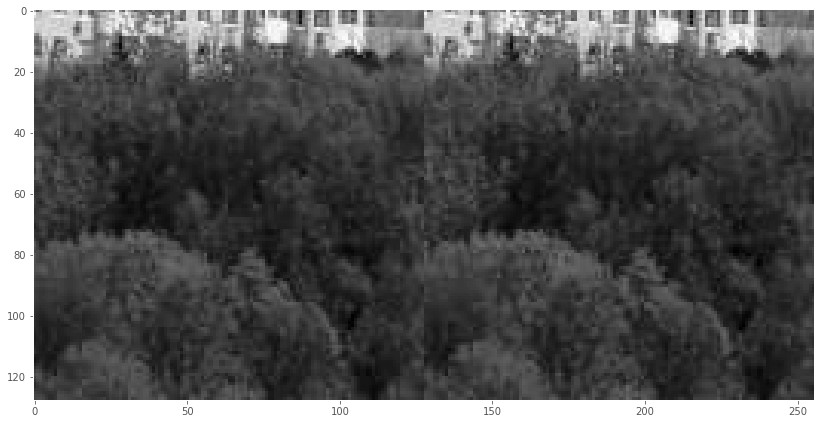

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[1])
sample_image = Image.open(sample_image_fp).convert("L")
plt.figure(figsize = (14,14))
plt.imshow(sample_image, cmap=matplotlib.cm.Greys_r)
print(sample_image_fp)

In [ ]:
def split_image(image):
    image = np.array(image)
    quality, poor = image[:, :128], image[:, 128:]
    return quality, poor

(128, 256)


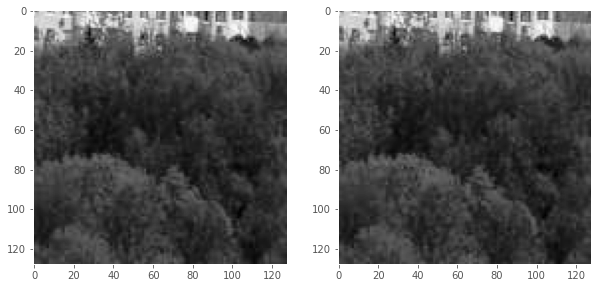

In [ ]:
sample_image = np.array(sample_image)
print(sample_image.shape)
quality, poor = split_image(sample_image)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(quality, cmap=matplotlib.cm.Greys_r)
axes[1].imshow(poor, cmap=matplotlib.cm.Greys_r)

In [ ]:
class SkylineDataset(Dataset):
    
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('L')
        quality, poor = self.split_image(image)
        quality = self.transform(quality)
        poor = self.transform(poor)
        return quality, poor
    
    def split_image(self, image):
        image = np.array(image)
        quality, poor = image[:, :128], image[:, 128:]
        return poor, quality

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor()
        ])
        return transform_ops(image)

In [ ]:
class SkylineDataset(Dataset):
    
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('L')
        quality, poor = self.split_image(image)

        quality_parts = self.crop_image(quality)
        poor_parts = self.crop_image(poor)

        quality = self.image_parts_to_tensor(quality_parts)
        poor = self.image_parts_to_tensor(poor_parts)
        return quality, poor
    
    def split_image(self, image):
        image = np.array(image)
        quality, poor = image[:, :1024], image[:, 1024:]
        return poor, quality

    def crop_image(self, image):
        image_parts = []
        for i in range (1,9):
            for j in range (1,9):
                image_parts.append(image[128*(i-1):128*i, 128*(j-1):128*j])
        return image_parts

    def image_parts_to_tensor(self, image_parts):
        result_tensor = self.transform(image_parts[0])
        for part in range(1, len(image_parts)):
            result_tensor = self.combine_chanels(result_tensor, image_parts[part])
        return result_tensor

    def combine_chanels(self, image_1, image_2):
        """
        image_1 is already a tensor
        """
        image_2 = self.transform(image_2)
        return torch.cat((image_1, image_2), 0)

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor()
        ])
        return transform_ops(image)

In [ ]:
dataset = SkylineDataset(train_dir)
print(len(dataset))

13056


In [ ]:
quality, poor = dataset[0]
print(quality.shape, poor.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [ ]:
batch_size = 16

In [ ]:
# train and validation data
train_data = SkylineDataset(train_dir)
val_data = SkylineDataset(val_dir)

# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
  
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
# learning parameters
batch_size = 64 # batch size, reduce if facing OOM error
epochs = 6 # number of epochs to train the SRCNN model for
lr = 1e-2 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print('Computation device: ', device)
model = SRCNN().to(device)
print(model)

Computation device:  cpu
SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function 
criterion = nn.MSELoss()

In [ ]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # backpropagation
        loss.backward()

        # update the parameters
        optimizer.step()

        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()

        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0

    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
                             
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()

            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr

In [ ]:
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

  0%|          | 0/816 [00:00<?, ?it/s]

Epoch 1 of 6


  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 27.386
Val PSNR: 29.000
Epoch 2 of 6


  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.306
Val PSNR: 22.805
Epoch 3 of 6


  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 28.526
Val PSNR: 29.881
Epoch 4 of 6


  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.700
Val PSNR: 29.619
Epoch 5 of 6


  0%|          | 0/816 [00:00<?, ?it/s]

Train PSNR: 29.650
Val PSNR: 27.415
Epoch 6 of 6


100%|██████████| 200/200 [00:57<00:00,  3.51it/s]

Train PSNR: 29.707
Val PSNR: 30.107
Finished training in: 65.323 minutes


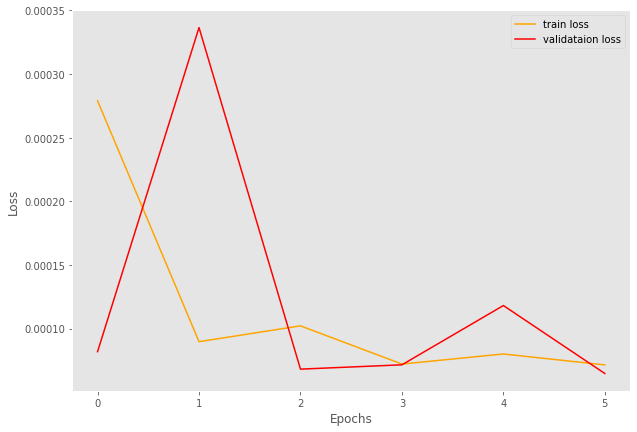

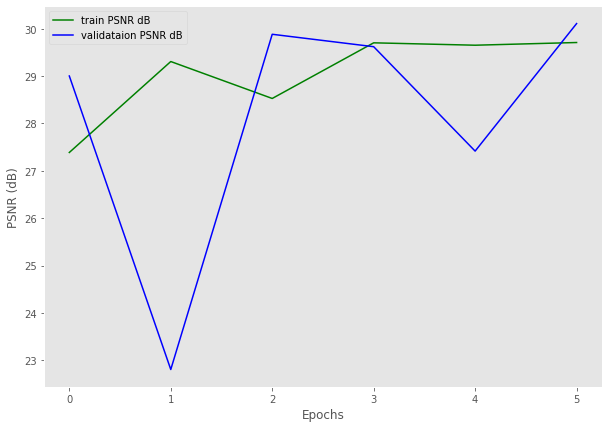

In [ ]:
#The loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

# save the model to disk
#print('Saving model...')
#torch.save(model.state_dict(), '../outputs/model.pth')

In [ ]:
from google.colab import files

torch.save(model.state_dict(), 'checkpoint_ready.pth')
files.download('checkpoint_ready.pth')

In [ ]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('checkpoint_ready.pth'))

<All keys matched successfully>

In [ ]:
test_batch_size = 8
dataset = SkylineDataset(train_dir)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [ ]:
X, Y = next(iter(data_loader))
Y_pred = model(X)

Text(0.5, 1.0, 'Predicted')

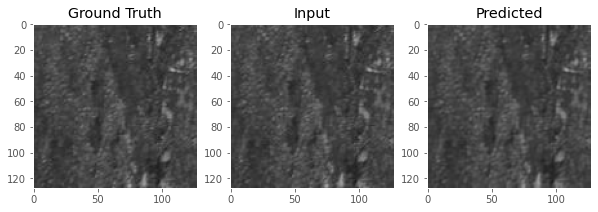

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
use_image = 7

truth = torchvision.utils.make_grid(Y[use_image], nrow=1)
truth = truth.permute(1, 2, 0).detach().numpy()
input = torchvision.utils.make_grid(X[use_image], nrow=1)
input = input.permute(1, 2, 0).detach().numpy()
pred = torchvision.utils.make_grid(Y_pred[use_image], nrow=1)
pred = pred.permute(1, 2, 0).detach().numpy()


axes[0].imshow(truth)
axes[0].set_title("Ground Truth")
axes[1].imshow(input)
axes[1].set_title("Input")
axes[2].imshow(pred)
axes[2].set_title("Predicted")